
# Mod 4 Project Submission

Please fill out:
* Student name: Thomas Hill & Jonathan Vasquez
* Student pace: Full Time
* Scheduled project review date/time: 07/31/2020
* Instructor name: Fangfang Lee


## Libraries

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import random
import os
import matplotlib.pyplot as plt
import shutil
import keras

from keras import models
from keras.models import Model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical 
from keras.optimizers import Adam, SGD, RMSprop 
from keras.callbacks import EarlyStopping
from random import randint
from pathlib import Path
from PIL import Image
from glob import glob 
from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)

## Import and view sample images

In [51]:
print(os.listdir('chest_xray/'))

['.DS_Store', 'test', 'train', 'val']


In [8]:
# define the directory that has the data
mainDIR = os.listdir('chest_xray/')
print(mainDIR)

['.DS_Store', 'test', 'train', 'val']


In [9]:
# define which folders contain our specific datasets
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

In [41]:
# Glob data together to get Normal and Pneumonia images
Normal = glob(train_folder + "NORMAL/*")
Pneumonia = glob(test_folder + "PNEUMONIA/*")

Display Normal Images


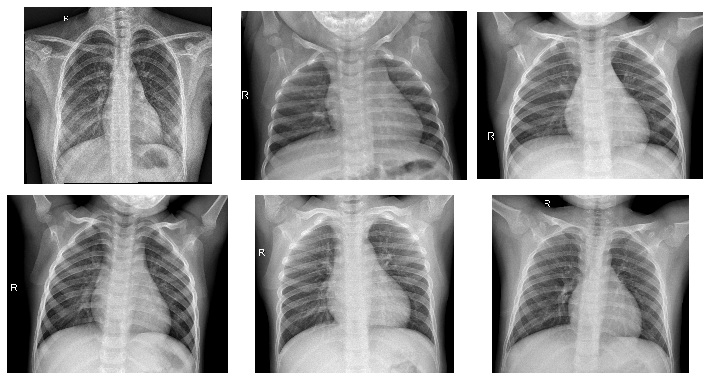

In [42]:
# Extract 6 random images from normal
random_images = [Normal[i] for i in range(6)]

print('Display Normal Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

Display Pneumonia Images


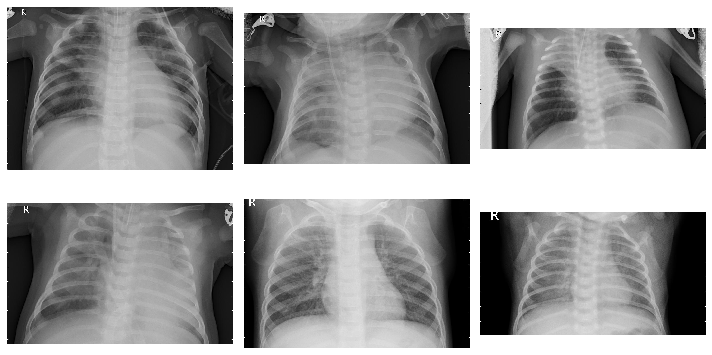

In [43]:
# Extract 6 random images from Pneumonia
random_images = [Pneumonia[i] for i in range(6)]

print('Display Pneumonia Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

## EDA

In [49]:
# Distribution of images with different category
Categories = ["Train", "Test", "Validation"]
Subcategories = ['Normal', 'Pneumonia']

Train = [1341, 390]
Test = [3875, 8]
Validation = [234, 8]

data = {'Categories':Categories,
        'Train':Train,
        'Test':Test,
        'Validation':Validation}

x = [(categories, subcategories) for categories in Categories for subcategories in Subcategories]
counts = sum(zip(data['Train'], data['Test'], data['Validation']), ())

source = ColumnDataSource(data=dict(x=x, counts=counts, color=Spectral6))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=900, title="Distribution of images with different category",
           tools="hover, pan, box_zoom, wheel_zoom, reset, save", tooltips= ("@x: @counts"))

p.vbar(x='x', top='counts', width=0.9, color='color', legend_field="x", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

Loading BokehJS ...

## Prepare data for modeling - address imbalance via augmentation

In [10]:
# build out how to data is fed into the model by using ImageDataGenerator to create three datasets
# using ImageDataGenerator allows us to augment our training set to account for the class imbalance

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory('chest_xray/val/',
                                                        target_size=(64, 64),
                                                        batch_size=32,
                                                        class_mode='binary')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Base CNN

In [14]:
# Vanilla CNN consisting of 2 Convolutional layers, 2 Pooling layers, Flatten, Dense, Dropout, and Output layer
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

In [15]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                200736    
_________________________________________________________________
dropout (Dropout)            (None, 32)               

## Base CNN Model Fit - 500 Epochs

In [17]:
cnn1 = cnn.fit(training_set,
                         steps_per_epoch = 163,
                         epochs = 500,
                         workers=-1,
                         validation_data = validation_generator)
                         #class_weight=class_weights)
                         

Epoch 1/500
163/163 [==============================] - 81s 495ms/step - loss: 0.4730 - accuracy: 0.7703 - precision: 0.7727 - recall: 0.9788 - val_loss: 0.4930 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 2/500
163/163 [==============================] - 80s 490ms/step - loss: 0.3408 - accuracy: 0.8355 - precision: 0.8611 - recall: 0.9283 - val_loss: 0.5007 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/500
163/163 [==============================] - 80s 491ms/step - loss: 0.2977 - accuracy: 0.8769 - precision: 0.9163 - recall: 0.9182 - val_loss: 0.6214 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/500
163/163 [==============================] - 81s 495ms/step - loss: 0.2811 - accuracy: 0.8892 - precision: 0.9278 - recall: 0.9226 - val_loss: 0.6234 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/500
163/163 [==============================] - 81s 495ms/step - loss: 0.2723 - a

Epoch 37/500
163/163 [==============================] - 80s 492ms/step - loss: 0.1613 - accuracy: 0.9419 - precision: 0.9747 - recall: 0.9463 - val_loss: 0.5579 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 38/500
163/163 [==============================] - 80s 490ms/step - loss: 0.1495 - accuracy: 0.9486 - precision: 0.9740 - recall: 0.9564 - val_loss: 0.3859 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 39/500
163/163 [==============================] - 80s 489ms/step - loss: 0.1561 - accuracy: 0.9438 - precision: 0.9693 - recall: 0.9546 - val_loss: 0.8512 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 40/500
163/163 [==============================] - 80s 490ms/step - loss: 0.1461 - accuracy: 0.9482 - precision: 0.9765 - recall: 0.9533 - val_loss: 0.6318 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 41/500
163/163 [==============================] - 80s 490ms/step - loss: 0.140

Epoch 73/500
163/163 [==============================] - 80s 489ms/step - loss: 0.1157 - accuracy: 0.9559 - precision: 0.9825 - recall: 0.9577 - val_loss: 0.4914 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 74/500
163/163 [==============================] - 80s 491ms/step - loss: 0.1189 - accuracy: 0.9572 - precision: 0.9803 - recall: 0.9618 - val_loss: 0.1786 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 75/500
163/163 [==============================] - 80s 491ms/step - loss: 0.1142 - accuracy: 0.9601 - precision: 0.9814 - recall: 0.9646 - val_loss: 0.4536 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 76/500
163/163 [==============================] - 80s 489ms/step - loss: 0.1145 - accuracy: 0.9601 - precision: 0.9806 - recall: 0.9654 - val_loss: 0.2844 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 77/500
163/163 [==============================] - 80s 490ms/step - loss: 0.111

Epoch 109/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0981 - accuracy: 0.9630 - precision: 0.9850 - recall: 0.9649 - val_loss: 0.5666 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 110/500
163/163 [==============================] - 80s 492ms/step - loss: 0.1125 - accuracy: 0.9609 - precision: 0.9837 - recall: 0.9634 - val_loss: 0.1722 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 111/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0984 - accuracy: 0.9643 - precision: 0.9845 - recall: 0.9672 - val_loss: 0.1815 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 112/500
163/163 [==============================] - 80s 491ms/step - loss: 0.0979 - accuracy: 0.9626 - precision: 0.9845 - recall: 0.9649 - val_loss: 0.3452 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 113/500
163/163 [==============================] - 80s 489ms/step - loss: 

Epoch 145/500
163/163 [==============================] - 80s 492ms/step - loss: 0.0920 - accuracy: 0.9659 - precision: 0.9866 - recall: 0.9672 - val_loss: 0.7821 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 146/500
163/163 [==============================] - 80s 491ms/step - loss: 0.0943 - accuracy: 0.9693 - precision: 0.9887 - recall: 0.9698 - val_loss: 0.2074 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 147/500
163/163 [==============================] - 80s 488ms/step - loss: 0.1008 - accuracy: 0.9611 - precision: 0.9839 - recall: 0.9634 - val_loss: 0.4332 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 148/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0984 - accuracy: 0.9657 - precision: 0.9873 - recall: 0.9662 - val_loss: 0.1507 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 149/500
163/163 [==============================] - 80s 491ms/step - loss: 

Epoch 181/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0946 - accuracy: 0.9670 - precision: 0.9887 - recall: 0.9667 - val_loss: 0.3432 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 182/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0876 - accuracy: 0.9705 - precision: 0.9877 - recall: 0.9724 - val_loss: 0.1456 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 183/500
163/163 [==============================] - 79s 488ms/step - loss: 0.0949 - accuracy: 0.9676 - precision: 0.9876 - recall: 0.9685 - val_loss: 0.2194 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 184/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0761 - accuracy: 0.9755 - precision: 0.9913 - recall: 0.9755 - val_loss: 0.1927 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 185/500
163/163 [==============================] - 80s 489ms/step - loss: 

Epoch 217/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0803 - accuracy: 0.9730 - precision: 0.9905 - recall: 0.9729 - val_loss: 0.7275 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 218/500
163/163 [==============================] - 79s 488ms/step - loss: 0.0918 - accuracy: 0.9676 - precision: 0.9879 - recall: 0.9683 - val_loss: 0.4789 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 219/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0819 - accuracy: 0.9705 - precision: 0.9882 - recall: 0.9719 - val_loss: 0.9701 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 220/500
163/163 [==============================] - 80s 488ms/step - loss: 0.0793 - accuracy: 0.9718 - precision: 0.9887 - recall: 0.9732 - val_loss: 0.3430 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 221/500
163/163 [==============================] - 80s 489ms/step - loss: 

Epoch 253/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0825 - accuracy: 0.9712 - precision: 0.9908 - recall: 0.9703 - val_loss: 0.5464 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 254/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0877 - accuracy: 0.9672 - precision: 0.9889 - recall: 0.9667 - val_loss: 1.2296 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 255/500
163/163 [==============================] - 79s 487ms/step - loss: 0.0809 - accuracy: 0.9722 - precision: 0.9890 - recall: 0.9734 - val_loss: 0.4707 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 256/500
163/163 [==============================] - 80s 488ms/step - loss: 0.0873 - accuracy: 0.9714 - precision: 0.9892 - recall: 0.9721 - val_loss: 0.2549 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 257/500
163/163 [==============================] - 80s 488ms/step - loss: 

Epoch 289/500
163/163 [==============================] - 79s 488ms/step - loss: 0.0766 - accuracy: 0.9734 - precision: 0.9916 - recall: 0.9724 - val_loss: 0.6921 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 290/500
163/163 [==============================] - 80s 491ms/step - loss: 0.0738 - accuracy: 0.9720 - precision: 0.9903 - recall: 0.9719 - val_loss: 0.6153 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 291/500
163/163 [==============================] - 80s 488ms/step - loss: 0.0724 - accuracy: 0.9734 - precision: 0.9893 - recall: 0.9747 - val_loss: 0.5493 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 292/500
163/163 [==============================] - 80s 491ms/step - loss: 0.0813 - accuracy: 0.9735 - precision: 0.9913 - recall: 0.9729 - val_loss: 0.3007 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 293/500
163/163 [==============================] - 80s 489ms/step - loss: 

Epoch 325/500
163/163 [==============================] - 80s 489ms/step - loss: 0.0694 - accuracy: 0.9745 - precision: 0.9900 - recall: 0.9755 - val_loss: 0.3770 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 326/500
163/163 [==============================] - 80s 492ms/step - loss: 0.0729 - accuracy: 0.9741 - precision: 0.9913 - recall: 0.9737 - val_loss: 0.2669 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 327/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0704 - accuracy: 0.9743 - precision: 0.9900 - recall: 0.9752 - val_loss: 0.3158 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 328/500
163/163 [==============================] - 80s 490ms/step - loss: 0.0642 - accuracy: 0.9766 - precision: 0.9914 - recall: 0.9770 - val_loss: 0.3356 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 329/500
163/163 [==============================] - 80s 491ms/step - loss: 

Epoch 361/500
163/163 [==============================] - 83s 509ms/step - loss: 0.0714 - accuracy: 0.9772 - precision: 0.9916 - recall: 0.9775 - val_loss: 0.5330 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 362/500
163/163 [==============================] - 81s 495ms/step - loss: 0.0698 - accuracy: 0.9755 - precision: 0.9908 - recall: 0.9760 - val_loss: 0.1888 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 363/500
163/163 [==============================] - 81s 494ms/step - loss: 0.0770 - accuracy: 0.9726 - precision: 0.9908 - recall: 0.9721 - val_loss: 0.3968 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 364/500
163/163 [==============================] - 80s 492ms/step - loss: 0.0682 - accuracy: 0.9766 - precision: 0.9924 - recall: 0.9760 - val_loss: 0.3027 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 365/500
163/163 [==============================] - 80s 493ms/step - loss: 

Epoch 397/500
163/163 [==============================] - 81s 497ms/step - loss: 0.0747 - accuracy: 0.9743 - precision: 0.9916 - recall: 0.9737 - val_loss: 0.2738 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 398/500
163/163 [==============================] - 83s 510ms/step - loss: 0.0638 - accuracy: 0.9781 - precision: 0.9937 - recall: 0.9768 - val_loss: 0.4264 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 399/500
163/163 [==============================] - 88s 542ms/step - loss: 0.0671 - accuracy: 0.9768 - precision: 0.9921 - recall: 0.9765 - val_loss: 0.5147 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 400/500
163/163 [==============================] - 98s 603ms/step - loss: 0.0678 - accuracy: 0.9751 - precision: 0.9913 - recall: 0.9750 - val_loss: 1.0701 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 401/500
163/163 [==============================] - 79s 483ms/step - loss: 

Epoch 433/500
163/163 [==============================] - 91s 558ms/step - loss: 0.0668 - accuracy: 0.9783 - precision: 0.9927 - recall: 0.9781 - val_loss: 0.9374 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 434/500
163/163 [==============================] - 89s 545ms/step - loss: 0.0628 - accuracy: 0.9789 - precision: 0.9922 - recall: 0.9794 - val_loss: 0.5705 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 435/500
163/163 [==============================] - 91s 557ms/step - loss: 0.0604 - accuracy: 0.9783 - precision: 0.9919 - recall: 0.9788 - val_loss: 0.4493 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 436/500
163/163 [==============================] - 85s 520ms/step - loss: 0.0610 - accuracy: 0.9785 - precision: 0.9927 - recall: 0.9783 - val_loss: 0.2482 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 437/500
163/163 [==============================] - 88s 541ms/step - loss: 

Epoch 469/500
163/163 [==============================] - 79s 487ms/step - loss: 0.0644 - accuracy: 0.9776 - precision: 0.9929 - recall: 0.9768 - val_loss: 0.6189 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 470/500
163/163 [==============================] - 81s 497ms/step - loss: 0.0614 - accuracy: 0.9793 - precision: 0.9932 - recall: 0.9788 - val_loss: 0.8111 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 471/500
163/163 [==============================] - 81s 497ms/step - loss: 0.0581 - accuracy: 0.9799 - precision: 0.9929 - recall: 0.9799 - val_loss: 0.8026 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 472/500
163/163 [==============================] - 80s 494ms/step - loss: 0.0646 - accuracy: 0.9766 - precision: 0.9924 - recall: 0.9760 - val_loss: 0.8893 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 473/500
163/163 [==============================] - 80s 488ms/step - loss: 

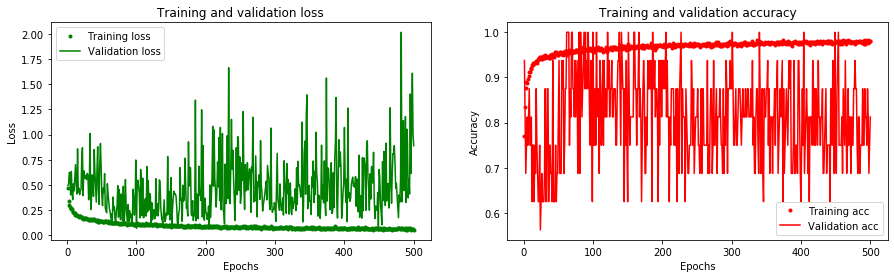

In [18]:
# visualization of loss and accuracy over the 500 epochs
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Base Model Results:

In [19]:
test_accu = cnn.evaluate(test_set)

20/20 [==============================] - 6s 316ms/step - loss: 0.6818 - accuracy: 0.9135 - precision: 0.8871 - recall: 0.9872


In [34]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 90.70512652397156 %


In [23]:
# Confusion matrix
Y_pred_base = cnn.predict(test_set)
Y_pred_concat = np.concatenate(Y_pred_base)
y_pred = np.where(Y_pred_concat > 0.5, 1, 0)  #np.where used to turn the predictions into 0 and 1
confusion_matrix(test_set.classes, y_pred)

array([[ 65, 169],
       [125, 265]])

In [25]:
# function to build a confusion matrix visualization
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 65 169]
 [125 265]]


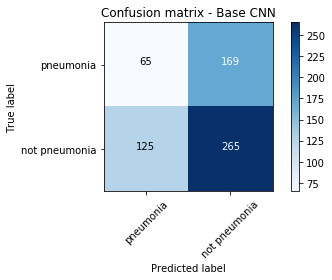

In [48]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_set.classes, y_pred), classes=['pneumonia', 'not pneumonia'], normalize=False,
                      title='Confusion matrix - Base CNN')

### Base Model Summary:

- Resulting accuracy score after 500 epochs is 91%
- Recall is the important metric here because we want to avoid False Negatives
- Recall score is 0.9872
- However, the model is NOT robust enough given the high amount of False Negatives (169)
- We will build another model to see if we can resolve this

## Transfer Learning - using VGG16 built by K. Simonyan, A. Zisserman

In [30]:
#This is a Convolutional Artificial Neural Network
#VGG16 Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(64,64,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)      

## Fitting the model - 10 epochs

In [31]:
optimizer = Adam(lr = 0.0001) #adam optimizer with a 0.0001 learning rate

early_stopping_monitor = EarlyStopping(patience = 5, monitor = "val_accuracy", mode="max", verbose = 1)

model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                                                   tf.keras.metrics.Recall(name='recall')], optimizer=optimizer)

history = model.fit(training_set, epochs=10, callbacks=[early_stopping_monitor], shuffle=True, 
                              validation_data=validation_generator, steps_per_epoch=163, verbose=1)

prediction = model.predict(training_set, verbose=1, steps=163)

Epoch 1/10
163/163 [==============================] - 373s 2s/step - loss: 0.5336 - accuracy: 0.7471 - precision: 0.7516 - recall: 0.9853 - val_loss: 0.6218 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
163/163 [==============================] - 388s 2s/step - loss: 0.2975 - accuracy: 0.8627 - precision: 0.9091 - recall: 0.9058 - val_loss: 1.7841 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
163/163 [==============================] - 420s 3s/step - loss: 0.2320 - accuracy: 0.9041 - precision: 0.9353 - recall: 0.9357 - val_loss: 0.6253 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 4/10
163/163 [==============================] - 419s 3s/step - loss: 0.1755 - accuracy: 0.9339 - precision: 0.9575 - recall: 0.9533 - val_loss: 0.5425 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/10
163/163 [==============================] - 392s 2s/step - loss: 0.1511 - accuracy: 0.9431

## Transfer Learning Model Results

In [32]:
test_accu = model.evaluate(test_set)

20/20 [==============================] - 12s 587ms/step - loss: 0.3057 - accuracy: 0.9071 - precision: 0.8971 - recall: 0.9615


In [33]:
test_accu

[0.305677592754364, 0.9070512652397156, 0.8971291780471802, 0.9615384340286255]

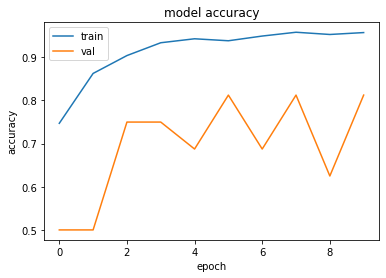

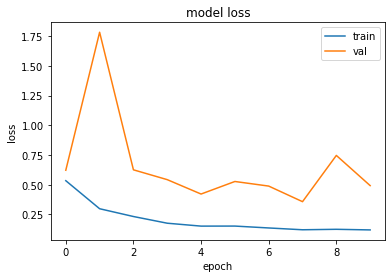

In [40]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [37]:
Y_pred_base_tl = model.predict(test_set)
Y_pred_concat_tl = np.concatenate(Y_pred_base_tl)
y_pred_tl = np.where(Y_pred_concat_tl > 0.5, 1, 0)
confusion_matrix(test_set.classes, y_pred_tl)

array([[ 81, 153],
       [125, 265]])

Confusion matrix, without normalization
[[ 81 153]
 [125 265]]


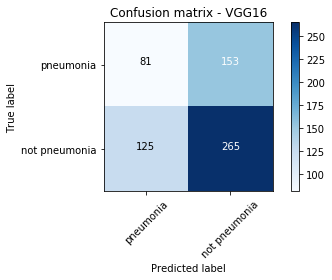

In [50]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_set.classes, y_pred_tl), classes=['pneumonia', 'not pneumonia'], normalize=False,
                      title='Confusion matrix - VGG16')

### Transfer Model Summary

- Resulting accuracy score after 10 epochs is 91%
- Recall score is 0.9615
- This model shows promise, in that it was better with predictions, however, many more epochs will need to be run in order to determine efficacy and potential for deployment.